In [1]:
"""
Trabalho computacional sobre algoritmos evolutivos para solução de sistemas de equações não lineares 
"""

'\nTrabalho computacional sobre algoritmos evolutivos para solução de sistemas de equações não lineares \n'

In [2]:
"""
Sistema de equações não lineares
"""
import numpy as np
import plotly.graph_objects as go
import pandas as pd

from src.equation_system import EquationSystem
from src.ga import real_coded_genetic_algorithm
from src.es import evolution_strategy

p1 = EquationSystem([
    lambda x: 0.8*(x[0]**2 + x[0] -1)*x[2] + 0.12*x[0]**2 + 2.16*x[0] - 0.12,
    lambda x: (1 + x[0]**2)*x[3] + 0.4*x[0]**2 - 1.6*x[0] - 0.4,
    lambda x: (1 + x[0]**2)*x[4] + x[0]**2 - 1,
    lambda x: (1 + x[0]**2)*x[5] + 0.8*(x[0]**2 + x[0] -1),
    lambda x: x[4]*x[6] - 0.02*x[5] - x[4] - x[2]*x[3] - 0.16*x[0],
    lambda x: x[6]**2 - 2*x[3]*x[6] + x[5]**2 + x[3]**2 - x[1]**2,
    lambda x: x[7] - x[1]*x[2],
    lambda x: 0.0476*x[2]*x[7]**12 + x[2] - 2.104
])

# p1 bounds
p1_lb = [-3, -1, -2, -1, -1, -0.5, -1.5, -1.5]
p1_ub = [1, 1, 2, 1, 1, 0.5, 1.5, 1.5]

p2 = EquationSystem([
    lambda x: x[4] + x[3] - 1.803,
    lambda x: (x[1] + x[2])*x[4] + 6.19116*x[3] - 1.803*(1.497 + 0.035),
    lambda x: x[5] + x[3] -0.328,
    lambda x: 0.28801*x[5] - x[1]*x[2]*x[4],
    lambda x: (-6.19116*x[0] + x[0]*x[2] + x[1]*x[4] - x[2]*x[4])*x[5] + x[0]*x[2]*x[4],
    lambda x: 1.571*x[6] + x[3] -1.803,
    lambda x: x[7] - 0.000856*x[6]**2,
    lambda x: (x[4] -x[0])*x[8] - x[0]*x[4],
    lambda x: x[8] - 377*x[1]*x[7]
])

# p2 bounds
p2_lb = [-0.5, -1, -1, -1, 1, -1, -1, 0, -1]
p2_ub = [0.5, 1, 1, 1, 2, 1, 1, 1, 1]

def save_results(score_histories, filename):
    df = pd.DataFrame(score_histories)
    df.columns = [f"iteration_{i}" for i in range(df.shape[1])]
    df = df.reset_index().rename(columns={"index": "epoch"})
    df.epoch = df.epoch + 1
    df.to_csv(filename, index=False)

### GA

#### Problema 01

In [3]:
max_gen = 1000
epochs = 50
idxmin_ga_p1, best_individual_ga_p1, score_histories_ga_p1 = real_coded_genetic_algorithm(
    p1, p1_lb, p1_ub,
    pop_size=50,
    max_gen=max_gen,
    pc=0.8,
    pm=0.1,
    alpha=0.5,
    sigma=0.1,
    elitism=True,
    epochs=epochs,
)

save_results(score_histories_ga_p1, "results/score_histories_ga_p1.csv")

In [4]:
fitness_scores = []
for i, history in enumerate(score_histories_ga_p1):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.9294403672900421, 1.0042124361419664, 0.3633541431575008, 0.058789539930205754, 0.5257849356449257, 1.0498605828814351, 1.0345963302211858, 0.11449922561915997, 0.5355941754754372, 0.36551127723266363, 0.6155252872174926, 0.5554297249444042, 0.1333955696447997, 0.10173490195975055, 1.0228109794305247, 0.2411096964900966, 1.05782967038437, 1.047504616773928, 1.0142818474383568, 0.08157915789201085, 0.8978829677372885, 0.7860708757739518, 0.2834576254069652, 0.08140880724521078, 0.9585742477781349, 0.26225784398344015, 0.21574017771186568, 1.0726031519748966, 0.21941032315952258, 0.3351664134339078, 0.997679519024353, 0.9786478979763394, 1.0283931892327864, 0.24486141146112692, 0.7193046314997044, 1.0306174450696468, 0.9999117683532419, 1.043906529056673, 1.0603605680041757, 0.12571886311693292, 0.07621399011432255, 1.0696989761075895, 0.16070454093806724, 1.05867275157466, 0.8697896703418572, 0.9781409640766786, 0.1277617300664835, 0.2112675332346253, 1.032272498613359, 0.10570473731

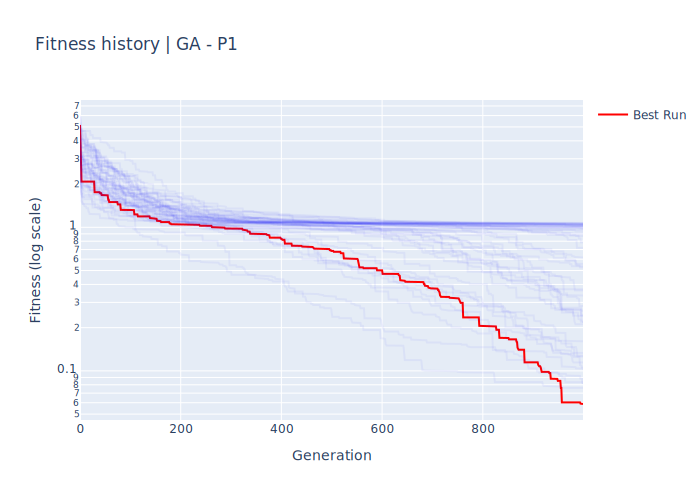

Best individual GA - P1: [0.28452589 1.10280091 1.0847407  0.63433229 0.92920042 0.37542308
 1.68119331 1.28407339]
Best score P1: 0.058789539930205754


In [5]:
fig = go.Figure()
for i, history in enumerate(score_histories_ga_p1):
    if i == idxmin_ga_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | GA - P1',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual GA - P1: {best_individual_ga_p1}')
print(f'Best score P1: {min(score_histories_ga_p1[idxmin_ga_p1])}')

#### Problema 02

In [6]:
idxmin_ga_p2, best_individual_ga_p2, score_histories_ga_p2 = real_coded_genetic_algorithm(
    p2, p2_lb, p2_ub,
    pop_size=50,
    max_gen=1000,
    pc=0.8,
    pm=0.1,
    alpha=0.5,
    sigma=0.1,
    elitism=True,
    epochs=50,
)

save_results(score_histories_ga_p2, "results/score_histories_ga_p2.csv")

In [7]:
fitness_scores = []
for i, history in enumerate(score_histories_ga_p2):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.006282710263959258, 0.0052050328853810975, 0.38396062235410927, 0.010254535313373616, 0.044155278516571535, 0.012534377532487503, 0.010692232008789325, 0.02519226670672338, 0.016665777259834102, 0.025189869282930797, 0.05736308758172094, 0.014422831704700963, 0.03512902478585747, 0.004663050887137367, 1.114039727908244, 0.4500973672748386, 0.20971769230433102, 0.00572387372765007, 0.017256670242399366, 0.007177558518902047, 0.009980132021672776, 0.01326812689915313, 0.010834612680792378, 0.011925253196431354, 0.013214798794764119, 0.0029084128513419, 0.009532419343266053, 0.007085960630688112, 0.009792358517663571, 0.009274247787952009, 0.004213647529338147, 0.0060025541810518005, 0.01861019211522712, 0.009634954797185524, 0.14148695586203247, 0.01116418558508378, 0.01617595263756159, 0.013944701485022403, 0.05905602407547863, 0.027759129669897714, 0.00376046458622484, 0.007333909846168059, 0.01178360781763799, 0.010477974131830157, 0.012927896097999167, 0.014124630739928791, 0.0202

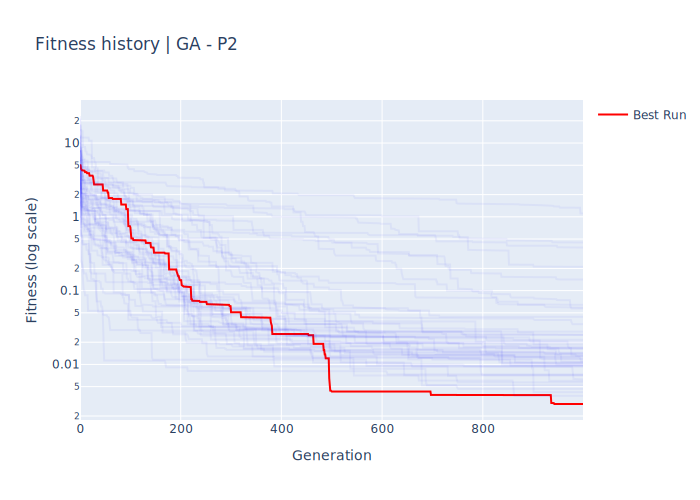

Best individual GA - P2: [ 0.05723356  0.03372553 -0.20677791  0.4795029   1.33684845 -0.16860074
  0.85010661  0.00399666  0.05784277]
Best score P2: 0.0029084128513419


In [8]:
fig = go.Figure()
for i, history in enumerate(score_histories_ga_p2):
    if i == idxmin_ga_p2:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | GA - P2',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual GA - P2: {best_individual_ga_p2}')
print(f'Best score P2: {min(score_histories_ga_p2[idxmin_ga_p2])}')

### Evolution Strategy

#### Problema 01

In [9]:
idxmin_es_p1, best_individual_es_p1, best_score_es_p1, score_histories_es_p1 = evolution_strategy(
    p1, p1_lb, p1_ub,
    n_iter=5000,
    step_size=0.15,
    mu=20,
    lam=100,
    epochs=50,
)
save_results(score_histories_es_p1, "results/score_histories_es_p1.csv")

Epoch 0000, Best: f([-0.29615701  0.95900964  0.08396677  0.89247141  0.60444782  0.41729772
Epoch 0000, Best: f([ 0.2194825  -0.4921996  -0.38325535  0.81837752  0.0154805  -0.34482029
Epoch 0000, Best: f([ 0.45197254 -0.61352087  0.51897671 -0.83757307  0.06381154 -0.15425248
Epoch 0000, Best: f([ 0.19406312  0.92430568  0.8199124   0.65227375  0.32661843 -0.14716003
Epoch 0001, Best: f([ 0.33597395  0.89437291  0.82991792  0.60274152  0.40824777 -0.04489724
Epoch 0002, Best: f([ 0.39062007  0.68090498  0.87717329  0.63427294  0.45034892 -0.06455788
Epoch 0002, Best: f([0.31830041 0.80480766 0.89158149 0.72889578 0.47979677 0.01599211
Epoch 0003, Best: f([ 0.21615339  0.97843669  0.88751926  0.71441001  0.31864327  0.43276785
Epoch 0005, Best: f([ 0.24919155  0.56800154  0.92467048  0.39684528  0.58261899 -0.01831611
Epoch 0006, Best: f([0.31367846 0.50737663 1.64125526 0.40415146 0.32074129 0.25325226
Epoch 0006, Best: f([0.103785   0.87087676 1.16675853 0.05639352 0.88620331 0.0746

In [10]:
fitness_scores = []
for i, history in enumerate(score_histories_es_p1):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.18698636130788174, 0.22248436046214995, 0.21421099646494854, 0.21009660623837761, 0.23329794769249898, 0.20630861742889062, 0.2020567562107585, 0.1914180306413815, 0.2275262081137907, 0.18253855683205997, 0.20610844406502268, 0.21219102139048468, 0.20389813556433925, 0.21148324224458376, 0.2133764692886611, 0.2202691881566008, 0.19638703234146124, 0.2156457989067781, 0.21790434923775082, 0.2079690497645757, 0.2051117672045544, 0.21182136786797143, 0.20276449556728074, 0.2477426563017976, 0.22344186236046354, 0.1768346648908909, 0.20147777503709877, 0.21108706321943346, 0.19670748643749383, 0.18792363113760738, 0.22297836418849185, 0.2104995295021116, 0.22276334315221577, 0.22494976965334892, 0.22881942170242509, 0.2334500287976897, 0.22530330880347768, 0.2157112492268552, 0.19970262433807884, 0.1824534399527895, 0.18309942418913625, 0.21104178770151635, 0.21176174077328813, 0.22820175053477865, 0.2212595383192503, 0.1907317684173364, 0.23307382802767102, 0.22232318019631486, 0.20286

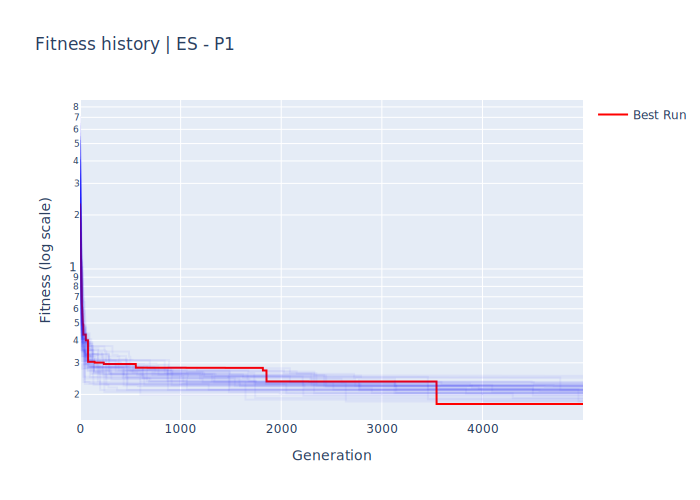

Best individual ES - P1: [0.26850788 0.9692527  1.05119316 0.59107479 0.92613143 0.35730813
 1.49912965 1.28419835]
Best score P1: 0.1768346648908909


In [11]:
fig = go.Figure()
for i, history in enumerate(score_histories_es_p1):
    if i == idxmin_es_p1:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | ES - P1',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual ES - P1: {best_individual_es_p1}')
print(f'Best score P1: {min(score_histories_es_p1[idxmin_es_p1])}')

#### Problema 02

In [12]:
idxmin_es_p2, best_individual_es_p2, best_score_es_p2, score_histories_es_p2 = evolution_strategy(
    p2, p2_lb, p2_ub,
    n_iter=5000,
    step_size=0.15,
    mu=20,
    lam=100,
    epochs=50,
)

save_results(score_histories_es_p2, "results/score_histories_es_p2.csv")

Epoch 0000, Best: f([-3.10479135e-01 -3.63187530e-01 -9.45487825e-01  7.70835724e-01
  1.96828402e+00 -4.26342515e-04  1.56879669e-01  2.65900080e-02
Epoch 0000, Best: f([ 0.19702544 -0.33439636 -0.43411508  0.77035269  1.81694369 -0.41613189
Epoch 0000, Best: f([ 0.25479047 -0.95118765 -0.35493256  0.5271482   1.02100653  0.6286923
Epoch 0000, Best: f([-3.13373288e-01 -7.77627228e-04 -5.87969614e-01  7.04906862e-01
  1.46831697e+00  7.02551742e-01  3.84114301e-01  2.89439988e-01
Epoch 0001, Best: f([-0.31162229  0.00423839  0.49943925  0.33591668  1.88761396  0.97914588
Epoch 0003, Best: f([ 0.30105533 -0.0610429  -0.17700258  0.53095952  1.85702557 -0.42363418
Epoch 0004, Best: f([ 0.10870415 -0.00374157 -0.17632499  0.44537162  1.90288971  0.80497463
Epoch 0005, Best: f([ 0.08943514 -0.14575648 -0.22356665  0.55319904  1.67973999  0.04369804
Epoch 0006, Best: f([0.06528539 0.28452097 0.47009777 0.24348757 1.45688131 0.70436757
Epoch 0006, Best: f([0.40698115 0.16335646 0.34680523 0.

In [13]:
fitness_scores = []
for i, history in enumerate(score_histories_es_p2):
    fitness_scores.append(history[-1])
print(fitness_scores)

# Estatísticas de exemplo
best = np.min(fitness_scores)
worst = np.max(fitness_scores)
mean = np.mean(fitness_scores)
std_dev = np.std(fitness_scores)
median = np.median(fitness_scores)

# Criar dataframe com os resultados
stats_df = pd.DataFrame({
    'Statistic': ['Best', 'Worst', 'Mean', 'Standard Deviation', 'Median'],
    'Value': [best, worst, mean, std_dev, median]
})

# Exportar para LaTeX
latex_table = stats_df.to_latex(index=False)
print(latex_table)

[0.05470183442447124, 0.05181303286855157, 0.046374625729344934, 0.03526726635153441, 0.027199233227202035, 0.028714948904289363, 0.02466652770800958, 0.032773992635622994, 0.03849359279676761, 0.05366281345376587, 0.03703660158226023, 0.039276219366308235, 0.03480336972713174, 0.034582266723486244, 0.06857889683934379, 0.044196678746539625, 0.03682742388548904, 0.0654823613858069, 0.050141099996783095, 0.029284116592565062, 0.03833362059343509, 0.04427590728169531, 0.019700446794323836, 0.051464966613286485, 0.03925323160562478, 0.04270652652074152, 0.05002504997888044, 0.03708338079348131, 0.036070353537484376, 0.044052249030640346, 0.034686169764069755, 0.05315189827255209, 0.017298757339089855, 0.05845759373487885, 0.044513740834065105, 0.04576158754985936, 0.06279756039671705, 0.027106145877278515, 0.03553626442742477, 0.033031605021697004, 0.05792573232520442, 0.033534969089256204, 0.025163100125004684, 0.03442626738535723, 0.04230933663160296, 0.04265480570762521, 0.041674345580

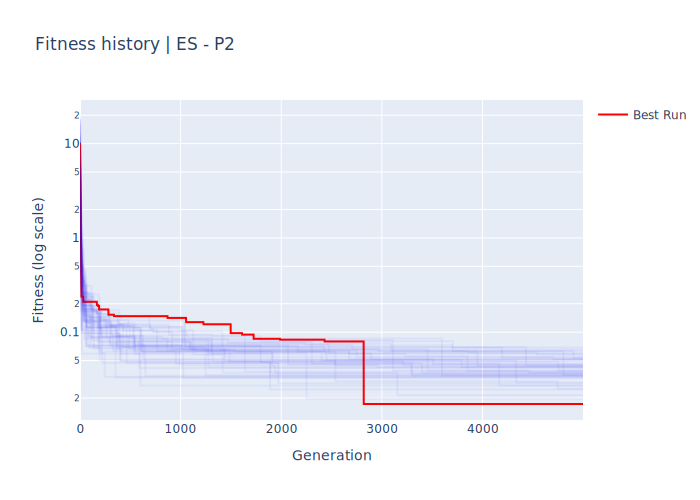

Best individual ES - P2: [ 0.38583044  0.09680357 -0.66847619  0.56484555  1.31556507 -0.24787006
  0.78590108  0.01265062  0.46243821]
Best score P2: 0.017298757339089855


In [14]:
fig = go.Figure()
for i, history in enumerate(score_histories_es_p2):
    if i == idxmin_es_p2:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=1, line=dict(color='red')))
    else:
        fig.add_trace(go.Scatter(y=history, mode='lines', opacity=0.05, line=dict(color='blue')))

fig.update_layout(
    title='Fitness history | ES - P2',
    xaxis_title='Generation',
    yaxis_title='Fitness (log scale)',
    yaxis_type='log'  # Definindo a escala logarítmica no eixo y
)

fig.for_each_trace(lambda trace: trace.update(showlegend=False) if trace.line.color == 'blue' else trace.update(name='Best Run'))
fig.show('svg')

print(f'Best individual ES - P2: {best_individual_es_p2}')
print(f'Best score P2: {min(score_histories_es_p2[idxmin_es_p2])}')